In [128]:
%matplotlib inline 

import pandas as pd
import numpy as np
from sklearn import cluster, metrics, preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use('fivethirtyeight')

## 1. Format the Data

In [2]:
df = pd.read_csv("../../assets/datasets/airport2.csv")

Convert the class labels, in this case the airports, to numeric. *Remember*, we've truncated the airport dataset for simplicty to make this part easy! 

In [6]:
le = preprocessing.LabelEncoder()
df["Airport"] = le.fit_transform(df["Airport"])

In [7]:
df.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,0,2004,242,235,71,46
1,0,2005,221,190,61,33
2,0,2006,392,329,71,124
3,0,2007,366,304,107,45
4,0,2008,333,300,79,42


## 2. Plot the data

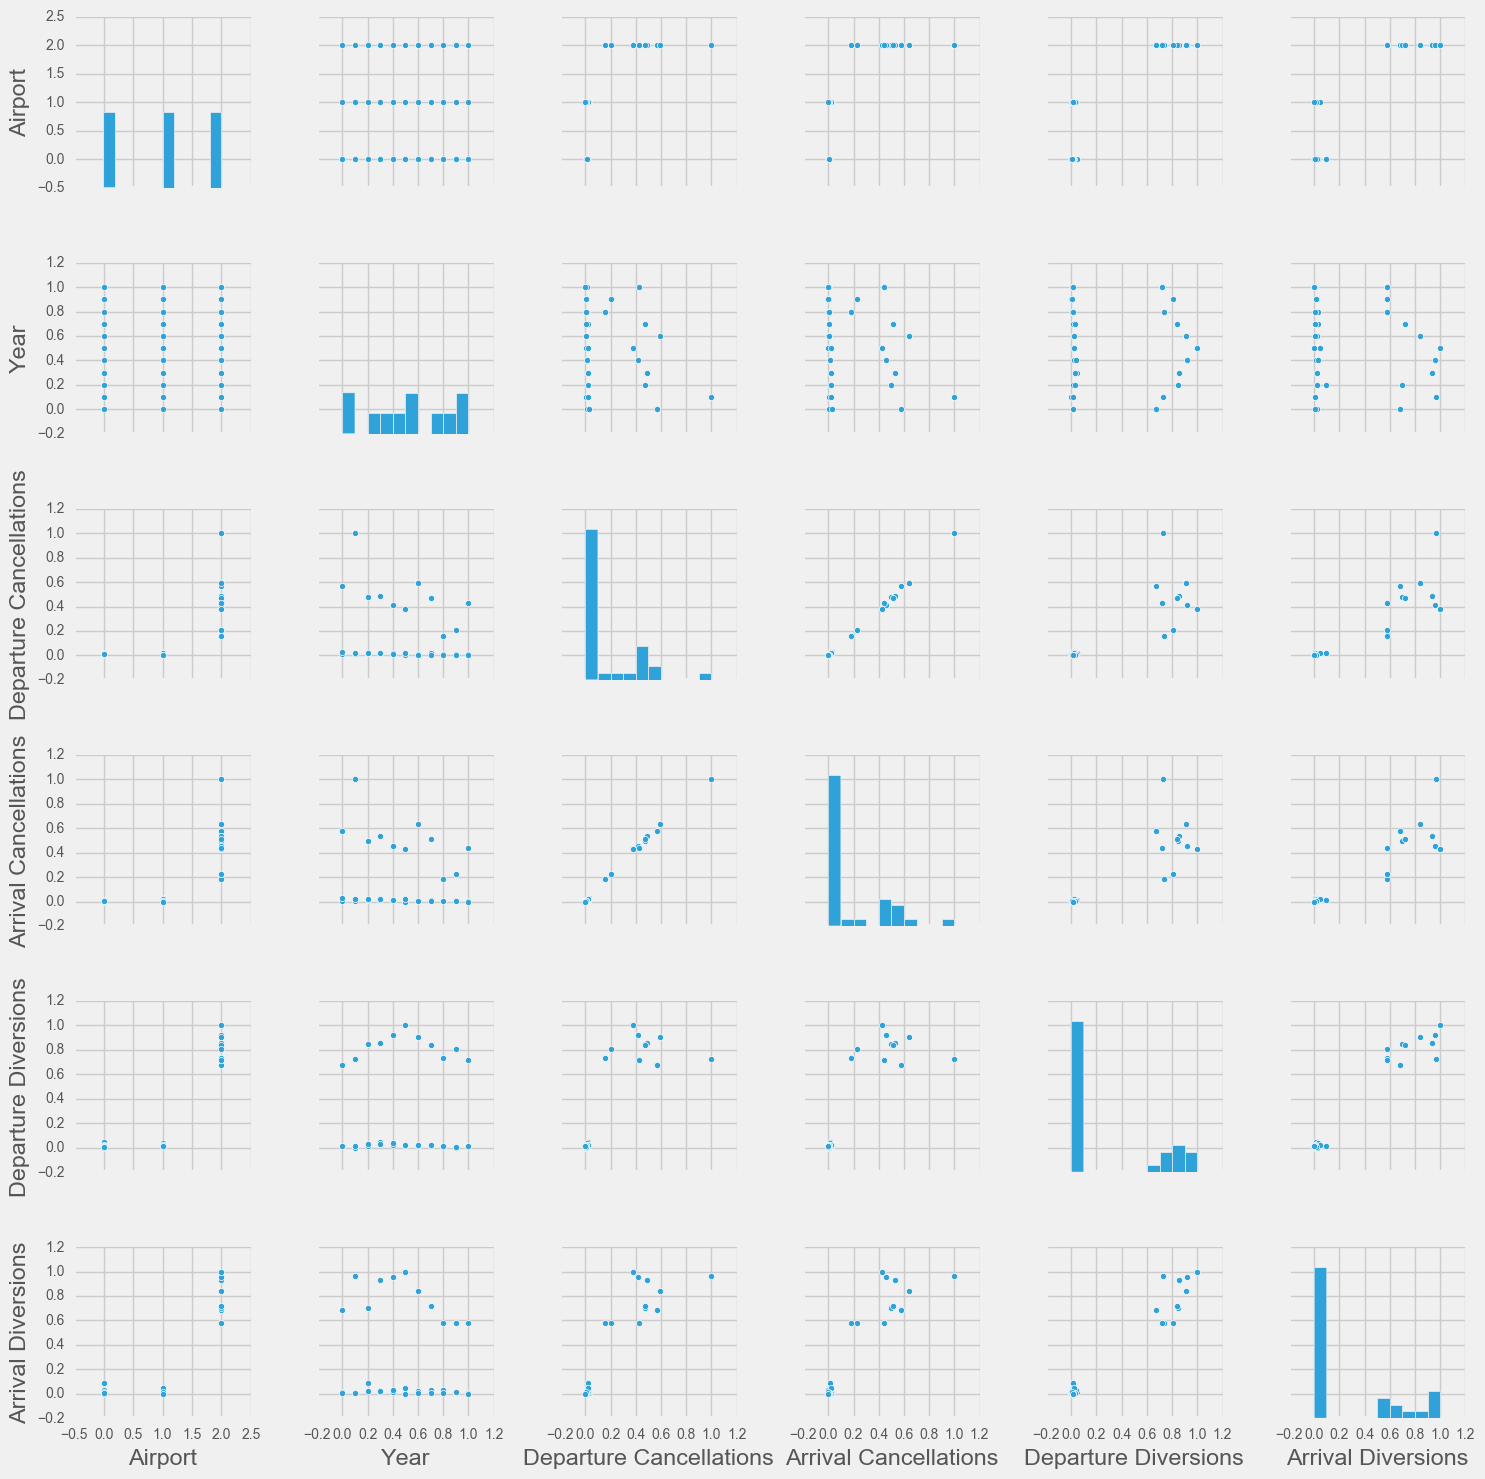

In [70]:
sns.pairplot(df);

In [11]:
scaler = preprocessing.MinMaxScaler()

In [12]:
df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])

## 3.  Perform a K-Means Clustering 

#### 3.1 Split the dataset into the attribute data and class labels

In [14]:
X = df.iloc[:, 1:]

In [15]:
y = df.iloc[:,0]

#### 3.2 Conduct the k-means clustering

In [16]:
kmeans = cluster.KMeans(n_clusters=3)

In [17]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

#### 3.3 Compute the labels and centroids

In [18]:
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [19]:
kmeans.cluster_centers_

array([[ 0.8       ,  0.00764243,  0.00430926,  0.01186441,  0.01522936],
       [ 0.5       ,  0.47001046,  0.49973968,  0.82099157,  0.77631359],
       [ 0.25      ,  0.01614333,  0.01296154,  0.01994018,  0.0233945 ]])

#### 3.4 Format the resulting predicted "y" variables and check the accuracy score, classification report, and confusion matrix

In [21]:
np.array(y)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [23]:
clus = kmeans.predict(X)

In [24]:
clus

array([2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [27]:
labs = np.zeros_like(clus)
for i in range(y.nunique()):
    mask = (clus == i)
    labs[mask] = stats.mode(y[mask])[0]

In [28]:
labs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [87]:
def eval_model(y_true, y_pred):
    print "Accuracy: {}".format(metrics.accuracy_score(y_true, y_pred))
    print
    print "Classification report"
    print 
    print metrics.classification_report(y_true, y_pred)
    conmat = metrics.confusion_matrix(y_true, y_pred)
    conmat = pd.DataFrame(conmat)
    return conmat

In [88]:
eval_model(y, labs)

Accuracy: 0.666666666667

Classification report

             precision    recall  f1-score   support

          0       0.50      1.00      0.67        11
          1       0.00      0.00      0.00        11
          2       1.00      1.00      1.00        11

avg / total       0.50      0.67      0.56        33



,0,1,2
0,11,0,0
1,11,0,0
2,0,0,11


**Question**: What are we understand from this these performance metrics? 

*It seems like 2 of the clusters were "close" enough such that clustering doesn't treat them as separate clusters.*

## 4. Extra Trees Classifier

In [89]:
etc = ExtraTreesClassifier()

In [90]:
etc.fit(X, labs)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [91]:
y_pred = etc.predict(X)

In [92]:
eval_model(labs, y_pred)

Accuracy: 1.0

Classification report

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        22
          2       1.00      1.00      1.00        11

avg / total       1.00      1.00      1.00        33



,0,1
0,22,0
1,0,11


## 5. KNN Classifier

In [93]:
knn = KNeighborsClassifier()

In [96]:
knn.fit(X, labs)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [97]:
y_pred2 = knn.predict(X)

In [98]:
eval_model(labs, y_pred2)

Accuracy: 1.0

Classification report

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        22
          2       1.00      1.00      1.00        11

avg / total       1.00      1.00      1.00        33



,0,1
0,22,0
1,0,11


## 6. Hierarchical Clustering

#### 6.1 Create the linkage for clustering

In [99]:
X2 = pd.DataFrame(X.sum(axis=1), columns = ["ref"])

In [100]:
for i in range(X2.shape[0]):
    X2[i] = [X2.ix[j, "ref"] - X2.ix[i,"ref"] for j in range(X2.shape[0])]

In [101]:
X3 = X2.copy()
del X3["ref"]
X3 = abs(X3)
X3.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.000000,0.073430,0.289053,0.348828,0.415476,0.475901,0.598162,0.731368,0.802726,0.888692,...,3.750831,2.677760,3.068120,3.108549,3.265730,3.533361,3.198480,2.408376,2.674681,3.120786
1,0.073430,0.000000,0.215622,0.275397,0.342045,0.402471,0.524731,0.657938,0.729296,0.815262,...,3.677400,2.604329,2.994689,3.035118,3.192299,3.459931,3.125049,2.334946,2.601251,3.047355
2,0.289053,0.215622,0.000000,0.059775,0.126423,0.186848,0.309109,0.442315,0.513673,0.599639,...,3.461778,2.388707,2.779067,2.819496,2.976677,3.244308,2.909427,2.119324,2.385628,2.831733
3,0.348828,0.275397,0.059775,0.000000,0.066648,0.127073,0.249334,0.382540,0.453898,0.539864,...,3.402003,2.328932,2.719292,2.759721,2.916902,3.184533,2.849652,2.059549,2.325853,2.771958
4,0.415476,0.342045,0.126423,0.066648,0.000000,0.060425,0.182686,0.315892,0.387250,0.473216,...,3.335355,2.262284,2.652644,2.693073,2.850254,3.117885,2.783004,1.992901,2.259205,2.705310


In [131]:
len(squareform(X3))

528

In [132]:
len(pdist(X))

528

In [133]:
Z = linkage(pdist(X), method="complete")

#### 6.2 Plot the Denrogram

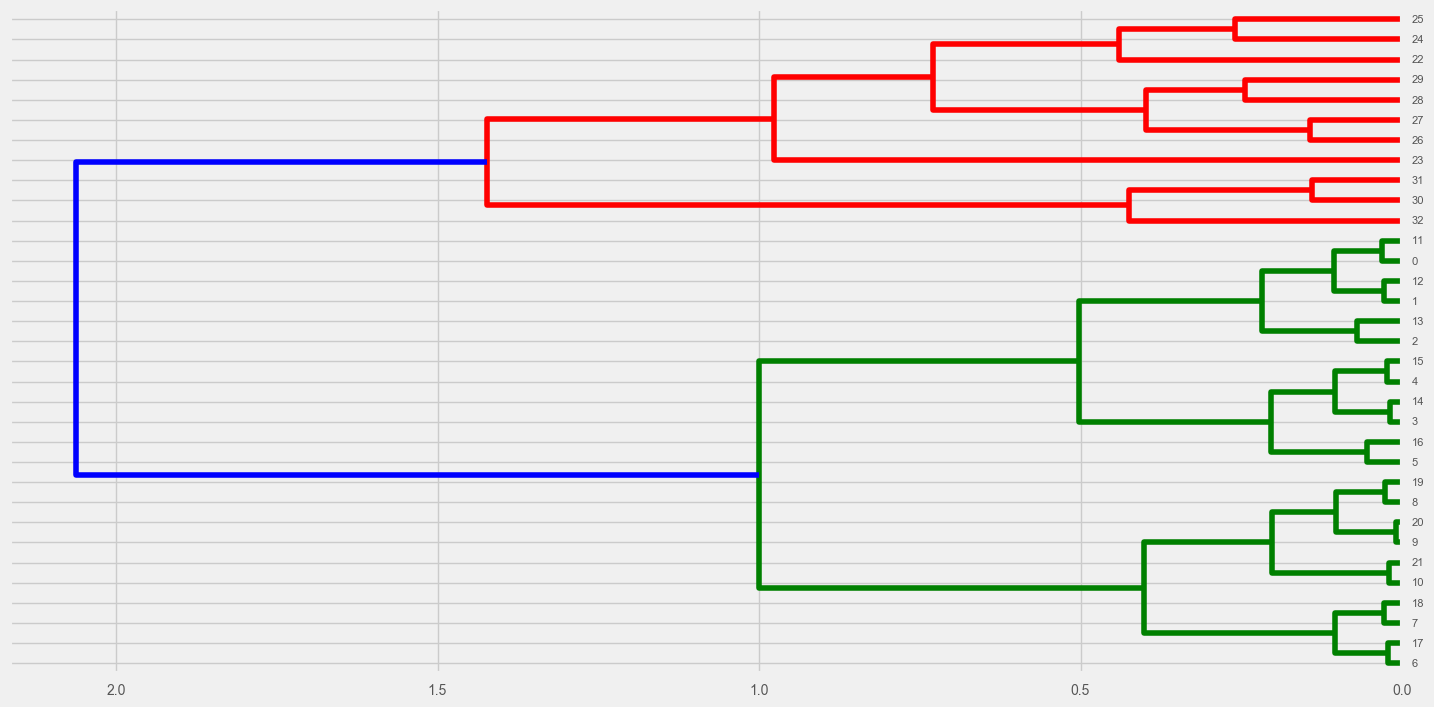

In [134]:
plt.subplots(figsize=(16,8));
dendrogram(Z, orientation="left");

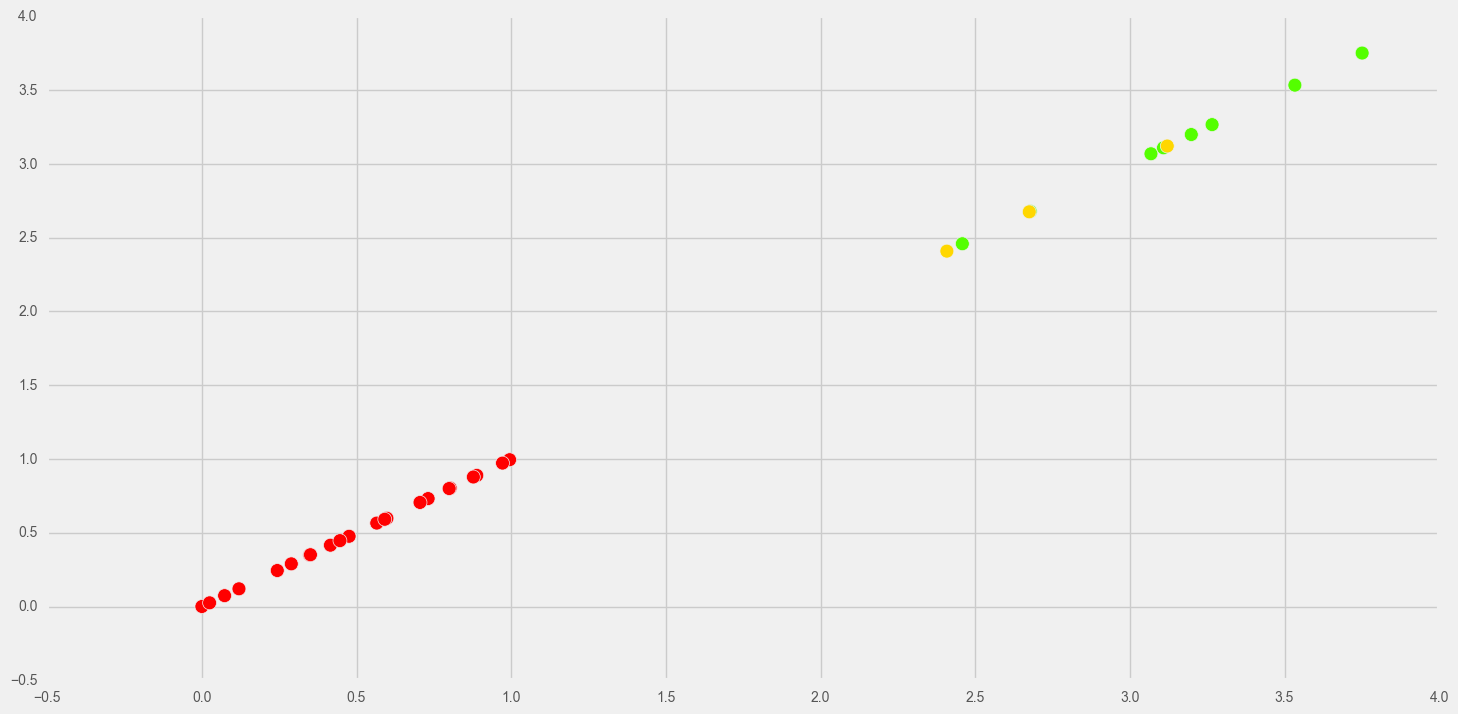

In [137]:
clusterX = fcluster(Z, 1.3, criterion="distance")
plt.subplots(figsize=(16,8));
plt.scatter(X3.iloc[:,0], X3.iloc[:,0], c=clusterX, cmap="prism", s=100);

In [138]:
clusterX

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 2, 2], dtype=int32)

In [139]:
labs2 = np.zeros_like(clusterX)
for i in range(1,4):
    mask = (clusterX == i)
    labs2[mask] = stats.mode(y[mask])[0]

In [140]:
clusterX

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 2, 2], dtype=int32)

In [141]:
eval_model(y, clusterX)

Accuracy: 0.424242424242

Classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        11
          1       0.50      1.00      0.67        11
          2       1.00      0.27      0.43        11
          3       0.00      0.00      0.00         0

avg / total       0.50      0.42      0.37        33



,0,1,2,3
0,0,11,0,0
1,0,11,0,0
2,0,0,3,8
3,0,0,0,0


## 4. Extra Trees Classifier

In [117]:
etc = ExtraTreesClassifier()

In [118]:
etc.fit(X, labs2)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [119]:
y_pred = etc.predict(X)

In [120]:
eval_model(labs2, y_pred)

Accuracy: 1.0

Classification report

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        22
          2       1.00      1.00      1.00        11

avg / total       1.00      1.00      1.00        33



,0,1
0,22,0
1,0,11


## 5. KNN Classifier

In [123]:
knn = KNeighborsClassifier()

In [124]:
knn.fit(X, labs2)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [125]:
y_pred2 = knn.predict(X)

In [126]:
eval_model(labs2, y_pred2)

Accuracy: 1.0

Classification report

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        22
          2       1.00      1.00      1.00        11

avg / total       1.00      1.00      1.00        33



,0,1
0,22,0
1,0,11
